In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from os.path import join, exists
import os
from ipywidgets import interact, SelectionSlider
from netCDF4 import Dataset
from scipy.linalg import cholesky
from scipy.stats import ttest_1samp, ttest_ind, ttest_ind_from_stats
from sklearn.decomposition import PCA
from deepsky.kriging import random_field_generator
from numba import jit

Generative Adversarial Networks (GANs) have demonstrated the ability to produce visually realistic synthetic examples from a set of data. Certain GAN configurations have been found to consistently produce good results, but there has not been justification for why these configurations work or why other configurations have issues. The purpose of this work is to evaluate GANs systematically on a synthetic spatial dataset where the properties of the dataset have been presecribed a priori. 

Distance between all points in lattice of random normal values Q: $D_{i,j}=\sqrt{(x_i-x_j)^2 + (y_i-y_j)^2}$.

Exponential kernel: $k=e^{-d/L}$

Correlation matrix: $C=k(D)$

Cholesky decomposition = $cho(C)=LL^*$

Correlated Random Field: $r=LQ$

De-correlated random field: $Q=L^{-1}r$


In [2]:
gan_path = "/d1/dgagne/random_gan_20170905/"
gan_param_combos = pd.read_csv(join(gan_path, "gan_param_combos.csv"), index_col="Index")

In [3]:
gan_param_combos

,activation,batch_size,beta_one,data_width,dropout_alpha,filter_width,generator_input_size,learning_rate,length_scale,min_conv_filters,min_data_width,output_activation,seed,train_size
Index,,,,,,,,,,,,,,
0,relu,256,0.5,32,0.0,3,16,0.0001,full;3,32,4,linear,14268489,131072
1,relu,256,0.5,32,0.0,3,16,0.0001,full;3,64,4,linear,14268489,131072
2,relu,256,0.5,32,0.0,3,16,0.0001,full;3,128,4,linear,14268489,131072
3,relu,256,0.5,32,0.0,3,16,0.0001,full;8,32,4,linear,14268489,131072
4,relu,256,0.5,32,0.0,3,16,0.0001,full;8,64,4,linear,14268489,131072
5,relu,256,0.5,32,0.0,3,16,0.0001,full;8,128,4,linear,14268489,131072
6,relu,256,0.5,32,0.0,3,16,0.0001,full;3;8,32,4,linear,14268489,131072
7,relu,256,0.5,32,0.0,3,16,0.0001,full;3;8,64,4,linear,14268489,131072
8,relu,256,0.5,32,0.0,3,16,0.0001,full;3;8,128,4,linear,14268489,131072


In [5]:
gan_path_intel = "/d1/dgagne/random_gan_20170828/"
gan_param_combos_intel = pd.read_csv(join(gan_path_intel, "gan_param_combos.csv"), index_col="Index")


In [6]:
gan_param_combos_intel

,activation,batch_size,beta_one,data_width,dropout_alpha,filter_width,generator_input_size,learning_rate,length_scale,min_conv_filters,min_data_width,seed,train_size
Index,,,,,,,,,,,,,
0,relu,256,0.5,32,0.0,5,32,0.0001,full;3,32,4,14268489,131072
1,relu,256,0.5,32,0.0,5,32,0.0001,full;3,64,4,14268489,131072
2,relu,256,0.5,32,0.0,5,32,0.0001,full;3,128,4,14268489,131072
3,relu,256,0.5,32,0.0,5,32,0.0001,full;8,32,4,14268489,131072
4,relu,256,0.5,32,0.0,5,32,0.0001,full;8,64,4,14268489,131072
5,relu,256,0.5,32,0.0,5,32,0.0001,full;8,128,4,14268489,131072
6,relu,256,0.5,32,0.0,5,32,0.0001,stacked;3;8;5,32,4,14268489,131072
7,relu,256,0.5,32,0.0,5,32,0.0001,stacked;3;8;5,64,4,14268489,131072
8,relu,256,0.5,32,0.0,5,32,0.0001,stacked;3;8;5,128,4,14268489,131072


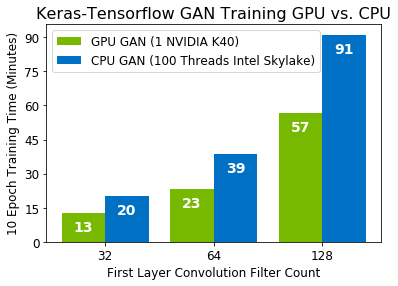

In [60]:
gpu_gan_combos = [37, 39, 41]
cpu_gan_combos = [0, 1, 2]
gpu_gan_times = np.zeros(3)
cpu_gan_times = np.zeros(len(cpu_gan_combos))
min_conv_filters = np.array([32, 64, 128])
plt.figure(figsize=(6, 4))
for c, combo in enumerate(gpu_gan_combos):
    hist_file = join(gan_path, "gan_loss_history_{0:04d}.csv".format(combo))
    loss_history = pd.read_csv(hist_file, parse_dates=["Time"])
    gpu_gan_times[c] = (loss_history["Time"].iloc[-1] - loss_history["Time"][0]).total_seconds()
for c, combo in enumerate(cpu_gan_combos):
    hist_file = join(gan_path_intel, "gan_loss_history_{0:04d}.csv".format(combo))
    loss_history = pd.read_csv(hist_file, parse_dates=["Time"])
    cpu_gan_times[c] = (loss_history["Time"].iloc[-1] - loss_history["Time"][0]).total_seconds()
plt.bar(np.array([0, 1, 2]), np.array(gpu_gan_times) / 60, 0.4, color="#76b900", label="GPU GAN (1 NVIDIA K40)")
plt.bar(np.array([0.4, 1.4, 2.4]), np.array(cpu_gan_times) / 60, 0.4, color="#0071c5", label="CPU GAN (100 Threads Intel Skylake)")
for i, g in enumerate(gpu_gan_times):
    plt.text(i, g/60 - 8, "{0:0.0f}".format(g/60), ha="center", color="white", fontsize=14, fontweight="bold")
for i, c in enumerate(cpu_gan_times):
    plt.text(i+0.4, c/60 - 8, "{0:0.0f}".format(c/60), ha="center", color="white", fontsize=14, fontweight="bold")
plt.legend(fontsize=12)
plt.xticks(np.array([0.2, 1.2, 2.2]), [32, 64, 128], fontsize=12)
plt.yticks(np.array([0, 15, 30, 45, 60, 75, 90]), fontsize=12)
plt.xlabel("First Layer Convolution Filter Count", fontsize=12)
plt.ylabel("10 Epoch Training Time (Minutes)", fontsize=12)
plt.title("Keras-Tensorflow GAN Training GPU vs. CPU", fontsize=16)
plt.savefig("gan_training_time_comparison.png", dpi=300, bbox_inches="tight")

In [9]:
hist_file = join(gan_path, "gan_loss_history_{0:04d}.csv".format(3))
loss_history = pd.read_csv(hist_file, parse_dates=["Time"])
loss_history["Time"].loc[loss_history["Epoch"] == 5].iloc[-1] - loss_history["Time"][0]

Timedelta('0 days 00:06:46.457503')

In [3]:
def distance_matrix(x, y):
    x_flat = x.reshape(-1, 1).astype(np.float64)
    y_flat = y.reshape(-1, 1).astype(np.float64)
    return np.sqrt((x_flat - x_flat.T) ** 2 + (y_flat - y_flat.T) ** 2)

@jit
def exp_kernel(distance, length_scale):
    return np.exp(-distance / length_scale)

x_f = np.arange(32)
y_f = np.arange(32)
x_g, y_g = np.meshgrid(x_f, y_f)
distances = distance_matrix(x_g, y_g)

In [4]:
sub_distances = np.array(distances, copy=True)
sub_distances[np.triu_indices(sub_distances.shape[0])] = 999999

@jit(nopython=True)
def spatial_covariance(distances, z, eval_distances, tolerance):
    covariances = np.zeros(eval_distances.size)
    z_flat = z.ravel()
    for d, eval_distance in enumerate(eval_distances):
        points_a, points_b = np.where(np.abs(distances - eval_distance) <= tolerance)
        covariances[d] = np.sum((z_flat[points_a] - z_flat[points_a].mean()) *
                                (z_flat[points_b] - z_flat[points_b].mean())) / (float(points_a.size) - 1)
        sd_a = np.sqrt(np.sum((z_flat[points_a] - z_flat[points_a].mean()) ** 2) / float(z_flat[points_a].size - 1))
        sd_b = np.sqrt(np.sum((z_flat[points_b] - z_flat[points_b].mean()) ** 2) / float(z_flat[points_b].size - 1))
        covariances[d] /= sd_a * sd_b
    return covariances



In [229]:
10847 / 678

15.998525073746313

In [13]:
def plot_loss_history(index):
    i = int(index)
    hist_file = join(gan_path, "gan_loss_history_{0:04d}.csv".format(index))
    plt.figure(figsize=(10, 5))
    print(gan_param_combos.loc[i, ["activation", 
                                   "dropout_alpha", 
                                   "filter_width", 
                                   "generator_input_size", 
                                   "length_scale",
                                   "min_conv_filters",
                                  ]])
    if exists(hist_file):
        loss_history = pd.read_csv(hist_file)
        plt.plot(loss_history["Gen Loss"], 'k-')
        plt.plot(loss_history["Disc Loss"], 'r-')
        plt.xlabel("Training Iteration")
        plt.ylabel("Loss")
        plt.text(2000, loss_history["Disc Loss"][2000] - 0.5, "Discriminator Loss", fontsize=12, color="red")
        plt.text(2000, loss_history["Gen Loss"][2000] + 0.5, "Generator Loss", fontsize=12, color="k")
        plt.ylim(0)
        #plt.plot(loss_history["Enc Loss"], 'b-')
    else:
        plt.text(0,0, "No Data")
    plt.show()
gan_loss_files = pd.Series(glob(join(gan_path, "gan_loss_history_*.csv")))
gan_loss_indices = gan_loss_files.str[-8:-4].values.astype(int)
valid_loss_indices = gan_param_combos.loc[np.in1d(gan_param_combos.index,gan_loss_indices) & 
                                          (gan_param_combos["train_size"] > 100000)].index.tolist()
interact(plot_loss_history, index=SelectionSlider(options=valid_loss_indices))

A Jupyter Widget

<function __main__.plot_loss_history>

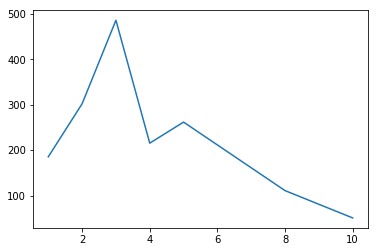

In [6]:
def plot_cov_by_epoch(gan_index):
    eval_distances = np.arange(1, 11)
    epochs = np.array([1, 2, 3, 4, 5, 8, 10])
    dist = float(gan_param_combos.loc[gan_index, "length_scale"].split(";")[-1])
    corr = exp_kernel(distances, dist)
    cho = cholesky(corr, lower=True)
    cho_inv = np.linalg.inv(cho)
    epoch_scores = np.zeros(epochs.shape)
    for e, epoch in enumerate(epochs):
        gan_patch_set = Dataset(join(gan_path, "gan_gen_patches_{0:04d}_epoch_{1:04d}.nc").format(gan_index, epoch))
        gan_patches = gan_patch_set.variables["gen_patch"][:, :, :, 0]
        gan_patch_set.close()
        patch_covs = np.zeros((gan_patches.shape[0], eval_distances.size))
        for g, gan_patch in enumerate(gan_patches):
            patch_covs[g] = spatial_covariance(sub_distances, np.matmul(cho_inv, gan_patch.reshape(1024, 1)).reshape(32,32), 
                                           eval_distances, 0.2)
        epoch_scores[e] = np.max(patch_covs.mean(axis=0) / (patch_covs.std(axis=0) / np.sqrt(gan_patches.shape[0])))
    plt.plot(epochs, np.abs(epoch_scores))
    plt.show()
plot_cov_by_epoch(0)
        

In [14]:
gan_index = 0
epoch = 10
corr_3 = exp_kernel(distances, 3)
cho_3 = cholesky(corr_3, lower=True)
eval_distances = np.arange(1, 11)
s_cov = np.zeros((100, eval_distances.size))
for i in range(100):
    s_cov[i] = spatial_covariance(sub_distances, np.matmul(cho_3, np.random.normal(size=(1024, 1))).reshape(32,32), eval_distances, 0)
def plot_patches(gan_index, epoch):
    eval_distances = np.arange(1, 11)
    print(gan_param_combos.loc[gan_index])
    num_patch_rows = 4
    gan_patch_set = Dataset(join(gan_path, "gan_gen_patches_{0:04d}_epoch_{1:04d}.nc").format(gan_index, epoch))
    gan_patches = gan_patch_set.variables["gen_patch"][0:num_patch_rows ** 2, :, :, 0]
    gan_patch_set.close()
    fig, axes = plt.subplots(num_patch_rows, num_patch_rows, figsize=(10, 10))
    plt.subplots_adjust(0.02, 0.02, 0.8, 0.8, wspace=0, hspace=0)
    a = 0
    ax_bot = fig.add_axes([0.87, 0.25, 0.15, 0.3], facecolor="w")
    dist = float(gan_param_combos.loc[gan_index, "length_scale"].split(";")[-1])
    corr = exp_kernel(distances, dist)
    cho = cholesky(corr, lower=True)
    cho_inv = np.linalg.inv(cho)
    cov_sum = np.zeros(eval_distances.shape)
    for (r, c), ax in np.ndenumerate(axes):
        ax.pcolormesh(gan_patches[a], vmin=-4, vmax=4, cmap="RdBu_r")
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        #ax_bot.set_yscale("log")
        patch_cov = spatial_covariance(sub_distances, gan_patches[a], eval_distances, 0.15)
        cov_sum += patch_cov
        ax_bot.plot(eval_distances, patch_cov, color='pink')
        ax_bot.set(ylim=(-0.1, 1), xticks=eval_distances, xlim=(1, 10))
        ax_bot.set_xlabel("Distance", fontsize=16)
        ax_bot.set_ylabel("SpatialCovariance", fontsize=16)
        a += 1
    title_str = "GAN Config: Min Conv Filters: {min_conv_filters}, Filter Width: {filter_width}\nGenerator Input Size: {generator_input_size}, Dropout $\\alpha$: {dropout_alpha}, Epoch: {epoch}"
    fig.suptitle(title_str.format(epoch=epoch, **gan_param_combos.loc[gan_index].to_dict()), y=0.85,x=0.42, fontsize=16)
    #ax_bot.plot(eval_distances, exp_kernel(eval_distances, dist), 'k--', lw=2)
    ax_bot.plot(eval_distances, s_cov.mean(axis=0), 'k--', lw=2)
    ax_bot.plot(eval_distances, cov_sum / a, 'r-', lw=2)
    ax_bot.set_facecolor("0.9")
    plt.savefig("gan_field_samples_bad.png", dpi=300, bbox_inches="tight", transparent=True)
    plt.show()
valid_loss_indices = gan_param_combos.loc[np.in1d(gan_param_combos.index,gan_loss_indices) & 
                                          (gan_param_combos["train_size"] > 100000) &
                                          (gan_param_combos["length_scale"] == "full;3")].index.tolist()
interact(plot_patches, gan_index=SelectionSlider(options=valid_loss_indices, value=0), 
         epoch=SelectionSlider(options=[1,2,3,4,5, 8, 10], value=10))

A Jupyter Widget

<function __main__.plot_patches>

In [42]:
gan_index = 3
epoch = 10
def plot_random_patches(gan_index, epoch):
    eval_distances = np.arange(1, 11)
    print(gan_param_combos.loc[gan_index])
    num_patch_rows = 4
    gan_patch_set = Dataset(join(gan_path, "gan_gen_patches_{0:04d}_epoch_{1:04d}.nc").format(gan_index, epoch))
    gan_patches = gan_patch_set.variables["gen_patch"][0:num_patch_rows ** 2, :, :, 0]
    gan_patch_set.close()
    fig, axes = plt.subplots(num_patch_rows, num_patch_rows, figsize=(10, 10))
    plt.subplots_adjust(0.02, 0.02, 0.8, 0.8, wspace=0, hspace=0)
    a = 0
    dist = float(gan_param_combos.loc[gan_index, "length_scale"].split(";")[-1])
    corr = exp_kernel(distances, dist)
    cho = cholesky(corr, lower=True)
    cho_inv = np.linalg.inv(cho)
    ax_bot = fig.add_axes([0.89, 0.25, 0.15, 0.3], facecolor="w")
    mean_cov = np.zeros((num_patch_rows ** 2, eval_distances.size))
    for (r, c), ax in np.ndenumerate(axes):
        rand_patch = np.matmul(cho_inv, gan_patches[a].reshape(1024, 1)).reshape(32,32)
        ax.pcolormesh(rand_patch, vmin=-4, vmax=4, cmap="RdBu_r")
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        noise_cov = spatial_covariance(sub_distances, rand_patch, eval_distances, 0.15)
        mean_cov[a] = noise_cov
        ax_bot.plot(eval_distances, noise_cov, color='pink')
        a += 1
    ax_bot.plot(eval_distances, mean_cov.mean(axis=0), 'r-', lw=2)
    ax_bot.plot(eval_distances, np.zeros(eval_distances.shape), 'k--', lw=2)
    ax_bot.set(ylim=(-0.15, 0.15), xticks=eval_distances, 
               xlim=(1, 10))
    ax_bot.set_xlabel("Distance", fontsize=16)
    ax_bot.set_ylabel("Spatial Covariance", fontsize=16)
    ax_bot.set_facecolor("0.9")
    ax_bot.text(1.5, 0.1, "t-score: {0:0.1f}".format(np.max(mean_cov.mean(axis=0) / mean_cov.std(axis=0) * np.sqrt(16))),
               fontsize=16)
    title_str = "GAN Config: Min Conv Filters: {min_conv_filters}, Filter Width: {filter_width}\nGenerator Input Size: {generator_input_size}, Dropout $\\alpha$: {dropout_alpha}, Epoch: {epoch}"
    fig.suptitle(title_str.format(epoch=epoch, **gan_param_combos.loc[gan_index].to_dict()), y=0.85,x=0.42, fontsize=16)
    plt.savefig("noise_gan_samples_bad.png", dpi=300, bbox_inches="tight", transparent=True)
    plt.show()
valid_loss_indices = gan_param_combos.loc[np.in1d(gan_param_combos.index,gan_loss_indices) & 
                                          (gan_param_combos["train_size"] > 100000) &
                                          (gan_param_combos["length_scale"] == "full;3")].index.tolist()
interact(plot_random_patches, gan_index=SelectionSlider(options=valid_loss_indices, value=0), 
         epoch=SelectionSlider(options=[1,2,3,4,5, 8, 10], value=10))


A Jupyter Widget

<function __main__.plot_random_patches>

In [191]:
gi = gan_param_combos.loc[0]
gi.to_dict()

{'activation': 'relu',
 'batch_size': 256,
 'beta_one': 0.5,
 'data_width': 32,
 'dropout_alpha': 0.0,
 'filter_width': 3,
 'generator_input_size': 16,
 'learning_rate': 0.0001,
 'length_scale': 'full;3',
 'min_conv_filters': 32,
 'min_data_width': 4,
 'seed': 14268489,
 'train_size': 16384}

In [5]:
def distance_matrix(x, y):
    x_flat = x.reshape(-1, 1).astype(np.float64)
    y_flat = y.reshape(-1, 1).astype(np.float64)
    return np.sqrt((x_flat - x_flat.T) ** 2 + (y_flat - y_flat.T) ** 2)

@jit
def exp_kernel(distance, length_scale):
    return np.exp(-distance / length_scale)

x_f = np.arange(32)
y_f = np.arange(32)
x_g, y_g = np.meshgrid(x_f, y_f)
distances = distance_matrix(x_g, y_g)

In [6]:
sub_distances = np.array(distances, copy=True)
sub_distances[np.triu_indices(sub_distances.shape[0])] = 999999

@jit(nopython=True)
def spatial_covariance(distances, z, eval_distances, tolerance):
    covariances = np.zeros(eval_distances.size)
    z_flat = z.ravel()
    for d, eval_distance in enumerate(eval_distances):
        points_a, points_b = np.where(np.abs(distances - eval_distance) <= tolerance)
        covariances[d] = np.sum((z_flat[points_a] - z_flat[points_a].mean()) *
                                (z_flat[points_b] - z_flat[points_b].mean())) / (float(points_a.size) - 1)
        sd_a = np.sum(z_flat[point_a] - z_flat[points_a].mean()) / float(z_flat[points_a].size - 1)
        sd_b = np.sum(z_flat[point_b] - z_flat[points_b].mean()) / float(z_flat[points_b].size - 1)
        covariances[d] /= sd_a * sd_b
    return covariances



In [7]:
corr = exp_kernel(distances, 3)
cho = cholesky(np.linalg.inv(corr), lower=True)
cho_inv = np.linalg.inv(cho)

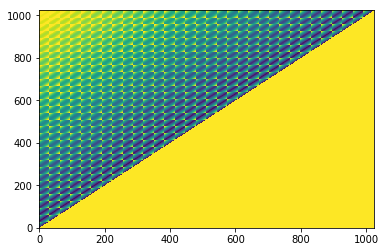

In [356]:
plt.pcolormesh(sub_distances, vmin=0, vmax=32)

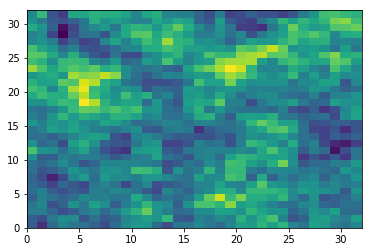

In [24]:
plt.pcolormesh(np.matmul(cho_inv.T, np.random.normal(size=(1024, 1))).reshape(32, 32))

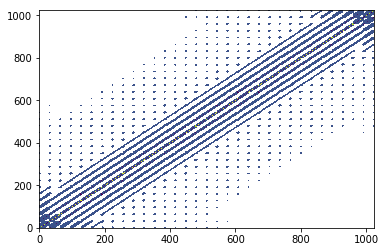

In [50]:
inv_corr = np.linalg.inv(corr)
plt.pcolormesh(np.ma.array(inv_corr, mask=np.abs(inv_corr) < 1e-3))

In [69]:
cho_2 = np.linalg.cholesky(corr)
np.linalg.inv(cho)

array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -1.02720414e+00,   1.43357886e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,  -1.02720414e+00,   1.43357886e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  1.06235193e-11,   3.92620662e-12,   6.09502888e-12, ...,
          1.71066812e+00,   0.00000000e+00,   0.00000000e+00],
       [  9.00140265e-12,   3.57176844e-12,   5.47371084e-12, ...,
         -7.48829857e-01,   1.70576468e+00,   0.00000000e+00],
       [  1.01749011e-11,   4.62519959e-12,   6.95283969e-12, ...,
          6.36912086e-03,  -7.57332942e-01,   1.65365555e+00]])

In [58]:
gan_index = 875
epoch = 10
gan_patch_set = Dataset(join(gan_path, "gan_gen_patches_{0:04d}_epoch_{1:04d}.nc").format(gan_index, epoch))
gan_patches = np.array(gan_patch_set.variables["gen_patch"][:, :, :, 0])
gan_patch_set.close()

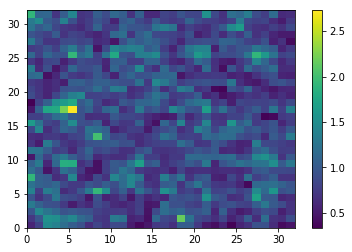

In [63]:
plt.pcolormesh(gan_patches.var(axis=0))
plt.colorbar()

In [72]:
from scipy.stats import probplot

0.91007131

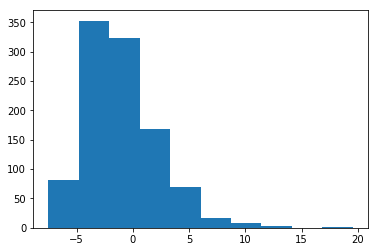

In [70]:
plt.hist((gan_patches.var(axis=0).ravel()  - 1) * np.sqrt( 256) / np.sqrt(2))
np.mean(gan_patches.var(axis=0).ravel())

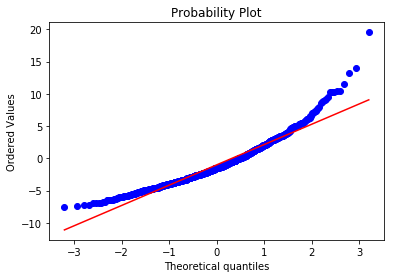

In [81]:
a, b = probplot((gan_patches.var(axis=0).ravel()  - 1) * np.sqrt( 256) / np.sqrt(2), plot=plt)
#plt.plot(a[0], a[1])

In [12]:
rand_patches = np.zeros(gan_patches.shape)
for p, patch in enumerate(gan_patches):
    rand_patches[p] = np.matmul(cho_inv, patch.reshape(patch.size, 1)).reshape(patch.shape)

In [53]:
r_gen = random_field_generator(x_g, y_g, [3])
random_data = np.array([next(r_gen) for i in range(256)])[:, :, :, 0]

0.99520342950706597

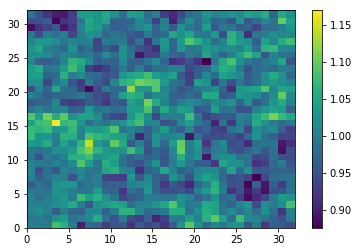

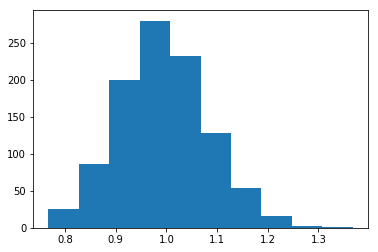

In [54]:
plt.pcolormesh(random_data.std(axis=0))
plt.colorbar()
plt.figure()
plt.hist(random_data.var(axis=0).ravel())
np.mean(random_data.var(axis=0).ravel())

In [13]:
eval_distances = np.arange(1, 9)
covs = np.zeros((gan_patches.shape[0], eval_distances.size))
for p, patch in enumerate(gan_patches):
    covs[p] = spatial_covariance(distances, patch, eval_distances, 0.1)


TypingError: Failed at nopython (nopython frontend)
Untyped global name 'point_a': cannot determine Numba type of <class 'object'>
File "<ipython-input-6-362eaae053a4>", line 12

In [22]:
eval_distances = np.arange(1, 9)
rand_covs = np.zeros((gan_patches.shape[0], eval_distances.size))
for p, patch in enumerate(rand_patches):
    rand_covs[p] = spatial_covariance(distances, patch, eval_distances, 0.1)

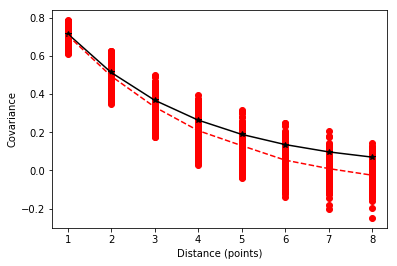

In [18]:
for cov in covs:
    plt.plot(eval_distances, cov, 'ro')
plt.plot(eval_distances, exp_kernel(eval_distances, 3), 'k*-')
plt.plot(eval_distances, covs.mean(axis=0), 'r--')
plt.xlabel("Distance (points)")
plt.ylabel("Covariance")

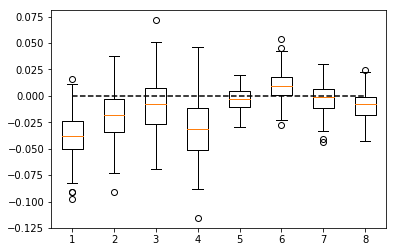

In [19]:
plt.boxplot(rand_covs, positions=eval_distances)
plt.plot(eval_distances, np.zeros(eval_distances.size), 'k--')
#plt.plot(eval_distances, exp_kernel(eval_distances, 3), 'k*-')

In [29]:
valid_patch_files = sorted(glob(join(gan_path, "gan_gen_patches_*_epoch_{0:04d}.nc".format(epoch))))
valid_patch_indices = pd.Series(valid_patch_files).str.split("/").str[-1].str.split("_").str[3].astype(int)


0        0
1        1
2        2
3        3
4        4
5        5
6        6
7        7
8        8
9        9
10      10
11      11
12      12
13      13
14      14
15      15
16      16
17      17
18      18
19      19
20      20
21      21
22      22
23      23
24      24
25      25
26      26
27      27
28      28
29      29
      ... 
422    882
423    883
424    884
425    885
426    886
427    887
428    888
429    889
430    890
431    891
432    892
433    893
434    894
435    895
436    896
437    897
438    898
439    899
440    900
441    901
442    902
443    903
444    904
445    905
446    906
447    907
448    908
449    909
450    910
451    911
Length: 452, dtype: int64


In [24]:

eval_distances = np.arange(1, 11)
gan_mean_cols = ["cov_mean_{0:02d}".format(x) for x in eval_distances]
gan_sd_cols = ["cov_sd_{0:02d}".format(x) for x in eval_distances]
gan_t_cols = ["cov_t_{0:02d}".format(x) for x in eval_distances]


In [49]:

epoch = 10
eval_distances = np.arange(1, 11)
valid_patch_files = sorted(glob(join(gan_path, "gan_gen_patches_*_epoch_{0:04d}.nc".format(epoch))))
valid_patch_indices = pd.Series(valid_patch_files).str.split("/").str[-1].str.split("_").str[3].astype(int)
full_3_combos = gan_param_combos.loc[(gan_param_combos["train_size"] > 100000) 
                                     & (gan_param_combos["length_scale"] == "full;3") 
                                     & np.in1d(gan_param_combos.index, valid_patch_indices.values)]
gan_mean_cols = ["cov_mean_{0:02d}".format(x) for x in eval_distances]
gan_sd_cols = ["cov_sd_{0:02d}".format(x) for x in eval_distances]
gan_t_cols = ["cov_t_{0:02d}".format(x) for x in eval_distances]
gan_stat_cols = gan_mean_cols + gan_sd_cols + gan_t_cols + ["mean_tscore"]
gan_stats = pd.DataFrame(np.zeros((full_3_combos.shape[0], len(gan_stat_cols))), 
                                   index=full_3_combos.index, columns=gan_stat_cols)
corr = exp_kernel(distances, 3)
cho = cholesky(corr, lower=True)
cho_inv = np.linalg.inv(cho)
rand_covs = np.zeros((256, eval_distances.size))
random_gen = random_field_generator(x_g, y_g, [3])
random_fields = np.stack([next(random_gen) for x in range(256)], axis=0)[:, :, :, 0]
random_noise = np.stack([np.matmul(cho_inv, 
                                   random_field.reshape(random_field.size, 1)).reshape(random_fields.shape[1:]) for random_field in random_fields], axis=0)
noise_cov = np.zeros((256, eval_distances.size))
for p, patch in enumerate(random_noise):
    noise_cov[p] = spatial_covariance(distances, patch, eval_distances, 0.2)
noise_mean = noise_cov.mean(axis=0)
noise_sd = noise_cov.std(axis=0)
for index in full_3_combos.index:
    print(index)
    gan_patch_file = join(gan_path, "gan_gen_patches_{0:04d}_epoch_{1:04d}.nc".format(index, epoch))
    if exists(gan_patch_file):
        gan_patch_ds = Dataset(gan_patch_file)
        gan_patches = np.array(gan_patch_ds.variables["gen_patch"][:, :, :, 0])
        gan_patch_ds.close()
        for p, patch in enumerate(gan_patches):
            rand_patch = np.matmul(cho_inv, patch.reshape(patch.size, 1)).reshape(patch.shape)
            rand_covs[p] = spatial_covariance(distances, rand_patch, eval_distances, 0.2)
        gan_stats.loc[index, gan_mean_cols] = rand_covs.mean(axis=0)
        gan_stats.loc[index, gan_sd_cols] = rand_covs.std(axis=0)
        #gan_stats.loc[index, gan_t_cols] = gan_stats.loc[index, gan_mean_cols].values / (gan_stats.loc[index, gan_sd_cols].values / np.sqrt(255))
        gan_stats.loc[index, gan_t_cols] = ttest_ind_from_stats(gan_stats.loc[index, gan_mean_cols].values,
                                                                gan_stats.loc[index, gan_sd_cols].values,
                                                                np.array([256] * len(eval_distances)),
                                                                noise_mean,
                                                                noise_sd,
                                                                np.array([256] * len(eval_distances)),
                                                                equal_var=False)[0]
        gan_stats.loc[index, "mean_tscore"] = np.abs(gan_stats.loc[index, gan_t_cols]).mean()
        #print(gan_stats.loc[index])

0
1
2
18
19
20
36
37
38
54
55
56
72
73
74
90
91
92
108
109
110
126
127
128
144
145
146
162
163
164
180
181
182
198
199
200
216
217
218
234
235
236
252
253
254
270
271
272
288
289
290
306
307
308
324
325
326
342
343
344
360
361
362
378
379
380
396
397
398
414
415
416
432
433
434
450
451
452
468
469
470
486
487
488
504
505
506
522
523
524
540
541
542
558
559
560
576
577
578
594
595
596
612
613
614
630
631
632
648
649
650
666
667
668
684
685
686
702
703
704
720
721
722
738
739
740
756
757
758
774
775
776
792
793
794
810
811
812
828
829
830
846
847
848
864
865
866
882
883
884
900
901
902
918
919
920
936
937
938
954
955
956


In [34]:
gan_stats.to_csv("gan_stats_3.csv", index_col="Index")

TypeError: to_csv() got an unexpected keyword argument 'index_col'

In [33]:
gan_stats.columns

Index(['Index', 'cov_mean_01', 'cov_mean_02', 'cov_mean_03', 'cov_mean_04',
       'cov_mean_05', 'cov_mean_06', 'cov_mean_07', 'cov_mean_08',
       'cov_mean_09', 'cov_mean_10', 'cov_sd_01', 'cov_sd_02', 'cov_sd_03',
       'cov_sd_04', 'cov_sd_05', 'cov_sd_06', 'cov_sd_07', 'cov_sd_08',
       'cov_sd_09', 'cov_sd_10', 'cov_t_01', 'cov_t_02', 'cov_t_03',
       'cov_t_04', 'cov_t_05', 'cov_t_06', 'cov_t_07', 'cov_t_08', 'cov_t_09',
       'cov_t_10', 'mean_tscore', 'max_tscore'],
      dtype='object')

In [35]:
gan_stats = pd.read_csv("gan_stats_3.csv", index_col="Index")

In [36]:
gan_stats["max_tscore"] = gan_stats[gan_t_cols].abs().max(axis=1)

In [53]:
full_8_combos = gan_param_combos.loc[(gan_param_combos["train_size"] > 100000) & (gan_param_combos["length_scale"] == "full;8")]
epoch = 10
eval_distances = np.arange(1, 12)
gan_mean_cols = ["cov_mean_{0:02d}".format(x) for x in eval_distances]
gan_sd_cols = ["cov_sd_{0:02d}".format(x) for x in eval_distances]
gan_t_cols = ["cov_t_{0:02d}".format(x) for x in eval_distances]
gan_stat_cols = gan_mean_cols + gan_sd_cols + gan_t_cols + ["mean_tscore"]
gan_stats_8 = pd.DataFrame(np.zeros((full_8_combos.shape[0], len(gan_stat_cols))), 
                                   index=full_8_combos.index, columns=gan_stat_cols)
rand_covs = np.zeros((256, eval_distances.size))
corr = exp_kernel(distances, 8)
cho = cholesky(corr, lower=True)
cho_inv = np.linalg.inv(cho)
rand_covs = np.zeros((256, eval_distances.size))
for index in full_8_combos.index:
    #print(index)
    gan_patch_file = join(gan_path, "gan_gen_patches_{0:04d}_epoch_{1:04d}.nc".format(index, epoch))
    if exists(gan_patch_file):
        gan_patch_ds = Dataset(gan_patch_file)
        gan_patches = np.array(gan_patch_set.variables["gen_patch"][:, :, :, 0])
        gan_patch_ds.close()
        for p, patch in enumerate(gan_patches):
            rand_patch = np.matmul(cho_inv, patch.reshape(patch.size, 1)).reshape(patch.shape)
            rand_covs[p] = spatial_covariance(distances, rand_patch, eval_distances, 0.1)
        gan_stats_8.loc[index, gan_mean_cols] = rand_covs.mean(axis=0)
        gan_stats_8.loc[index, gan_sd_cols] = rand_covs.std(axis=0)
        gan_stats_8.loc[index, gan_t_cols] = gan_stats_8.loc[index, gan_mean_cols].values / (gan_stats_8.loc[index, gan_sd_cols].values / np.sqrt(255))
        gan_stats_8.loc[index, "mean_tscore"] = np.abs(gan_stats_8.loc[index, gan_t_cols]).mean()
        print(index, gan_stats_8.loc[index, "mean_tscore"])

7 42.6580390954
9 38.0265973955
11 48.965432449
43 17.9671956726
45 66.2402198612
47 45.2525851462
79 21.244884429
81 39.6988619645
83 65.0257081484
115 48.8522889495
117 15.7315451959
119 16.8946346184
151 22.8901419471
153 35.2535345307
155 33.0760681037
187 25.2510745627
189 28.3691390441
191 14.2761869927
223 62.5439063854
225 70.7470432597
227 47.1191009702
259 23.1588687321
261 86.6963700758
263 28.1562100108
295 49.1664393121
297 45.9426490674
299 52.9327368566
331 45.3291741736
333 25.8304098727
335 15.8528830405
367 42.9046512679
369 41.3567188634
371 22.7615742325
403 36.330473527
405 20.5936771559
407 14.5722404837
439 65.0371250412
441 64.680665292
443 47.0757911011
475 31.5549032687
477 100.374162588
479 49.6057280891
511 36.0381472264
513 63.63195934
515 109.132433756
547 26.9784884896
549 33.2520925861
551 11.1553222126
583 61.5373925349
585 26.4329538797
587 8.6229802289
619 34.4529066493
621 15.4007775884
623 12.0321730955
655 33.283261333
657 19.2180914764
659 28.9913

In [39]:
param_stats = pd.merge(gan_stats, gan_param_combos, left_index=True, right_index=True)
#param_stats_8 = pd.merge(gan_stats_8, gan_param_combos, left_index=True, right_index=True)

In [32]:
gan_stats

(162, 33)

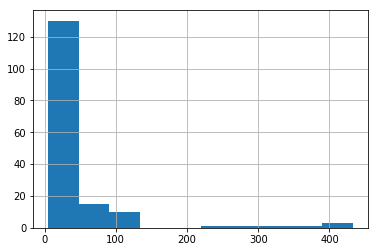

In [41]:
param_stats["max_tscore"].hist()

In [40]:
print(param_stats.groupby(["activation"])["max_tscore"].apply(np.median))
print(param_stats.groupby(["activation"])["max_tscore"].apply(np.argmax))

activation
leaky    15.507505
relu     50.752835
selu     16.500513
Name: max_tscore, dtype: float64
activation
leaky    919
relu      74
selu     578
Name: max_tscore, dtype: int64


In [43]:
print(param_stats.groupby(["generator_input_size"])["max_tscore"].apply(np.median))
print(param_stats.groupby(["generator_input_size"])["max_tscore"].apply(np.argmin))

generator_input_size
16     19.105375
32     22.417304
128    22.170320
Name: max_tscore, dtype: float64
generator_input_size
16     758
32     452
128    902
Name: max_tscore, dtype: int64


In [44]:
print(param_stats.groupby(['dropout_alpha'])["mean_tscore"].apply(np.median))
print(param_stats.groupby(['dropout_alpha'])["mean_tscore"].apply(np.argmin))

dropout_alpha
0.00    8.228535
0.05    7.664564
0.10    8.563551
Name: mean_tscore, dtype: float64
dropout_alpha
0.00    739
0.05    452
0.10    902
Name: mean_tscore, dtype: int64


In [46]:
print(param_stats.groupby(['filter_width'])["max_tscore"].apply(np.median))
print(param_stats.groupby(['filter_width'])["max_tscore"].apply(np.argmin))

filter_width
3    21.267528
5    21.401540
Name: max_tscore, dtype: float64
filter_width
3    902
5    739
Name: max_tscore, dtype: int64


In [47]:
print(param_stats.groupby(['min_conv_filters'])["max_tscore"].apply(np.median))
print(param_stats.groupby(['min_conv_filters'])["max_tscore"].apply(np.argmin))

min_conv_filters
32     27.954511
64     20.433561
128    15.915263
Name: max_tscore, dtype: float64
min_conv_filters
32     558
64     739
128    902
Name: max_tscore, dtype: int64


mean_tscore     33.877
max_tscore     94.5549
Name: 1, dtype: object


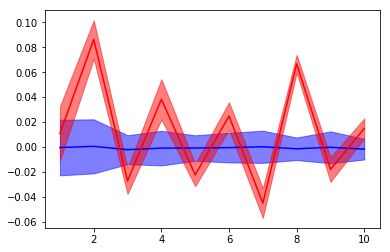

In [171]:
ex = 1
plt.fill_between(eval_distances, noise_mean + noise_sd, noise_mean - noise_sd, color="b", alpha=0.5)
plt.plot(eval_distances, noise_mean, color="b")
u_lim = np.array(param_stats.loc[ex, gan_mean_cols].values + param_stats.loc[ex, gan_sd_cols].values, dtype=np.float64)
l_lim = np.array(param_stats.loc[ex, gan_mean_cols].values - param_stats.loc[ex, gan_sd_cols].values, dtype=np.float64)
print(param_stats.loc[ex, ["mean_tscore", "max_tscore"]])
plt.fill_between(eval_distances, 
                 u_lim,
                 l_lim,
                 color="r", alpha=0.5)
plt.plot(eval_distances, param_stats.loc[ex, gan_mean_cols], color="red")


In [153]:
param_stats.loc[1407, gan_t_cols]

cov_t_01     -7.97257
cov_t_02      2.39093
cov_t_03      4.20877
cov_t_04     -3.28483
cov_t_05     -2.21631
cov_t_06   -0.0768287
cov_t_07     -7.72382
cov_t_08      4.09919
cov_t_09      1.95301
cov_t_10      3.85434
Name: 1407, dtype: object

In [82]:
param_stats.loc[1117]

cov_mean_01              -0.0297912
cov_mean_02              -0.0127551
cov_mean_03            -0.000402064
cov_mean_04              0.00267466
cov_mean_05             -0.00466377
cov_mean_06            -0.000987787
cov_sd_01                 0.0207328
cov_sd_02                 0.0234849
cov_sd_03                 0.0117921
cov_sd_04                 0.0177017
cov_sd_05                  0.010566
cov_sd_06                 0.0121523
cov_t_01                   -15.3405
cov_t_02                   -6.31712
cov_t_03                   0.693606
cov_t_04                    3.56443
cov_t_05                   -4.28517
cov_t_06                  -0.615584
mean_tscore                 5.13608
activation                     selu
batch_size                      256
beta_one                        0.5
data_width                       32
dropout_alpha                   0.1
filter_width                      3
generator_input_size             32
learning_rate                0.0001
length_scale                

In [89]:
param_stats.groupby(["activation", "generator_input_size",  "min_conv_filters"])["max_tscore"].apply(np.argmin)

activation  generator_input_size  min_conv_filters
leaky       16                    32                  810
                                  64                  865
                                  128                 758
            32                    32                  882
                                  64                  775
                                  128                 776
            128                   32                  846
                                  64                  739
                                  128                 902
relu        16                    32                  162
                                  64                  163
                                  128                 164
            32                    32                  288
                                  64                  181
                                  128                 290
            128                   32                  306
                     

In [33]:
rand_covs.mean(axis=0) / (rand_covs.std(axis=0) / np.sqrt(256))

array([-39.0067822 ,  17.84221841, -21.81347203,  76.18985832,
       -15.86412843, -11.76313301, -17.21443753,  35.21271735,
         4.25939047,  -8.31191961, -26.27969042,   8.29072105,
         0.61216273,  -3.64385412,  -7.86679877,  18.42345865])

In [34]:
rand_covs.mean(axis=0)

array([-0.065216  ,  0.04923398, -0.03695568,  0.24437319, -0.01359776,
       -0.01294718, -0.02038573,  0.04384881,  0.00615182, -0.01006078,
       -0.02731359,  0.00564907,  0.00064464, -0.00341985, -0.00746097,
        0.04176786])

In [152]:
np.sqrt(np.mean(ttest_1samp(rand_covs, 0, axis=0).statistic ** 2))

13.623668933971674

In [360]:
?np.cov

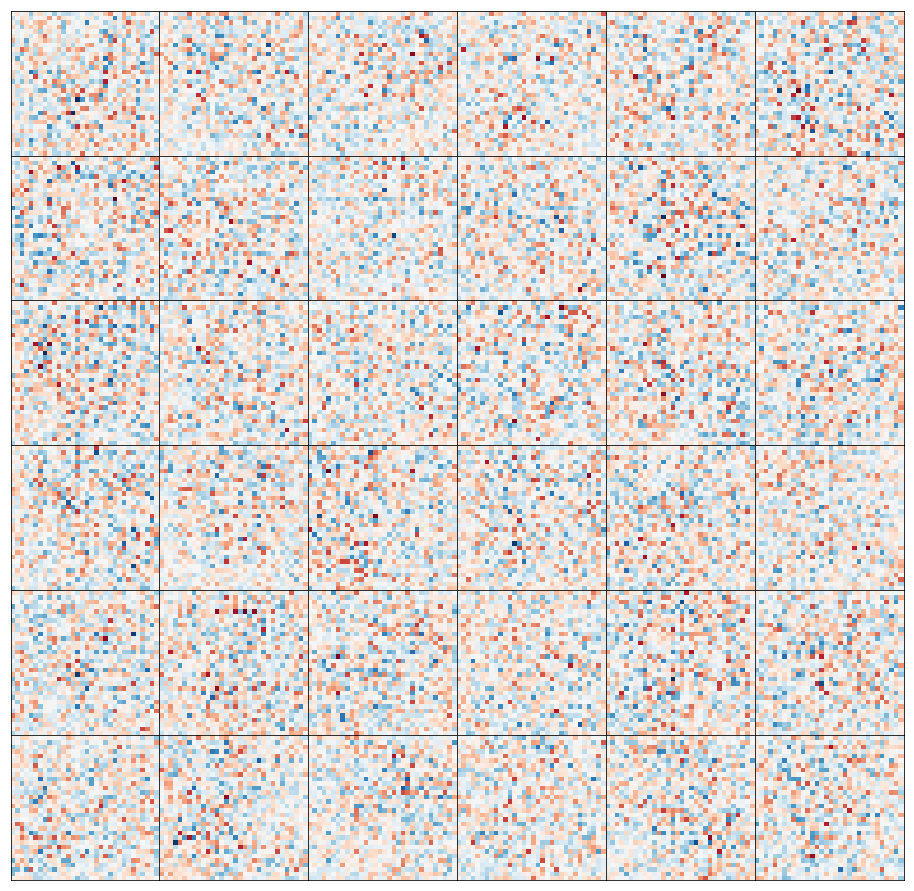

In [116]:
fig, axes = plt.subplots(num_patch_rows, num_patch_rows, figsize=(16, 16))
plt.subplots_adjust(wspace=0, hspace=0)
for (r, c), ax in np.ndenumerate(axes):
    ax.pcolormesh(rand_patches[a], vmin=-4, vmax=4, cmap="RdBu_r")
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    a += 1


In [294]:
e = np.random.normal(size=(1024, 1))
f = np.random.normal(size=(1024, 1))
corr_3 = exp_kernel(distances, 3)
corr_8 = exp_kernel(distances, 8)
cho_3 = cholesky(corr_3, lower=True)
cho_8 = cholesky(corr_8, lower=True)
out = np.matmul(cho_3, e) + np.matmul(cho_8, f)
e_again = np.matmul(np.linalg.inv(cho_3), out).reshape(32, 32)

In [369]:
@jit(nopython=False)
def spatial_covariance_2(distances, z, eval_distances, tolerance):
    covariances = np.zeros(eval_distances.size)
    z_flat = z.ravel()
    for d, eval_distance in enumerate(eval_distances):
        points_a, points_b = np.where(np.abs(distances - eval_distance) <= tolerance)
        covariances[d] = np.cov(z_flat[points_a], z_flat[points_b])[0, 1] / z_flat.var()
        #covariances[d] /= (z_flat[points_a].std() * z_flat[points_b].std())
    return covariances


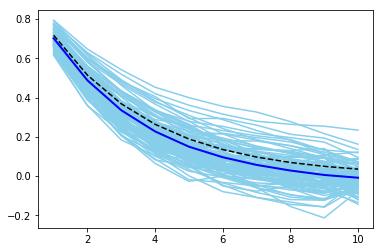

In [378]:
corr_3 = exp_kernel(distances, 3)
cho_3 = cholesky(corr_3, lower=True)

s_cov = np.zeros((100, eval_distances.size))
for i in range(100):
    s_cov[i] = spatial_covariance(sub_distances, np.matmul(cho_3, np.random.normal(size=(1024, 1))).reshape(32,32), eval_distances, 0)
    plt.plot(eval_distances, s_cov[i], color='skyblue')
plt.plot(eval_distances, np.mean(s_cov,axis=0), color="b", lw=2)
plt.plot(eval_distances, exp_kernel(eval_distances, 3), 'k--')

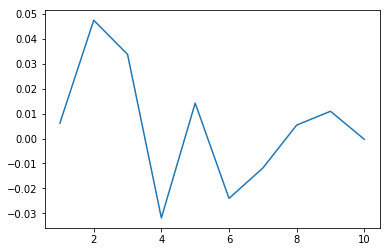

In [344]:
plt.plot(eval_distances, spatial_covariance(distances, e_again, eval_distances, 0.1))

In [163]:
rand_patches = np.zeros(gan_patches.shape)
for p, patch in enumerate(gan_patches.data):
    rand_patches[p] = np.matmul(cho_inv, patch.reshape(patch.size, 1)).reshape(patch.shape)

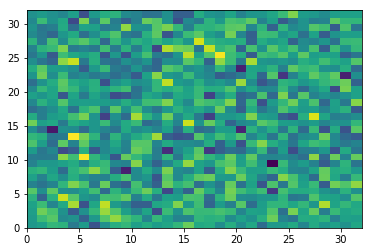

In [85]:
pc = PCA(n_components=256)
pc.fit(gan_patches.reshape(256, 32 * 32))

PCA(copy=True, iterated_power='auto', n_components=256, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

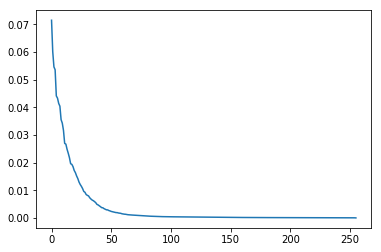

In [103]:
plt.plot(pc.explained_variance_ratio_)

In [94]:
eigout = np.linalg.eig(corr)

(0, 128)

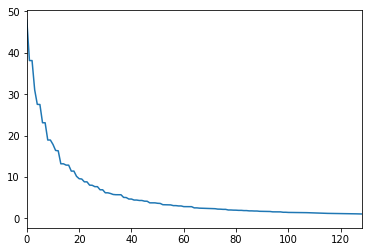

In [104]:
plt.plot(np.sort(eigout[0])[::-1])
plt.xlim(0, 128)

In [122]:
from deepsky.kriging import random_field_generator

In [123]:
gen = random_field_generator(x_g, y_g, np.array([3]))

In [148]:
random_fields = np.stack([next(gen) for x in range(256)], axis=0)

In [149]:
cho_inv_3 = np.linalg.inv(cho_3)
noise_covs = np.zeros((256, eval_distances.size))
for r, random_field in enumerate(random_fields):
    noise_field = np.matmul(cho_inv_3, random_field[:, :, 0].reshape(1024, 1))
    noise_covs[r] = spatial_covariance(distances, noise_field, eval_distances, 0.1)
    

In [150]:
noise_covs.std(axis=0)

array([ 0.02054843,  0.02272894,  0.02513495,  0.0254657 ,  0.01041655,
        0.01437884])

In [152]:
noise_covs.mean(axis=0)

array([-0.00255267, -0.00218324, -0.00317764,  0.00275801, -0.00147864,
       -0.00113355])

In [153]:
ttest_ind(rand_covs, noise_covs, equal_var=False)

Ttest_indResult(statistic=array([ -8.05092816,  33.46475569,  -7.22116618,  17.3566552 ,
       -22.9570681 ,   5.56908625]), pvalue=array([  5.86287860e-015,   2.03140336e-130,   1.88685073e-012,
         4.02716521e-051,   4.17010300e-080,   4.15643488e-008]))

In [145]:
ttest_1samp(rand_covs, 0)

Ttest_1sampResult(statistic=array([-12.95852276,  44.09539693, -12.42970937,  21.20795537,
       -32.17485343,   6.45167646]), pvalue=array([  7.61738210e-030,   2.59875591e-121,   4.77504214e-028,
         3.17736928e-058,   9.32901043e-092,   5.52611530e-010]))

dict_keys(['caps', 'boxes', 'whiskers', 'means', 'medians', 'fliers'])


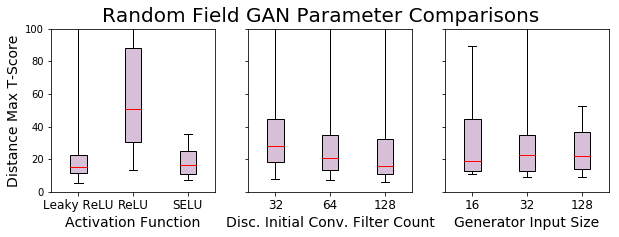

In [48]:
activations = np.sort(param_stats["activation"].unique())
long_act = np.array(["Leaky ReLU", "ReLU", "SELU"])
conv_counts = np.array([32, 64, 128])
gen_inputs = np.array([16, 32, 128])
act_tscores = []
for activation in activations:
    act_tscores.append(param_stats.loc[param_stats["activation"] == activation, "max_tscore"])
conv_tscores = []
for conv_count in conv_counts:
    conv_tscores.append(param_stats.loc[param_stats["min_conv_filters"] == conv_count, "max_tscore"])
gen_tscores = []
for gen_input in gen_inputs:
    gen_tscores.append(param_stats.loc[param_stats["generator_input_size"] == gen_input, "max_tscore"])
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
boxes = axes[0].boxplot(act_tscores, whis=[1, 99], showfliers=False, patch_artist=True, )
print(boxes.keys())
for box in boxes["boxes"]:
    box.set_facecolor("thistle")
for med in boxes["medians"]:
    med.set_color("red")
axes[0].set_ylim(0, 150)
axes[0].set_xticklabels(long_act, fontsize=12)
axes[0].set_ylabel("Distance Max T-Score", fontsize=14)
axes[0].set_xlabel("Activation Function", fontsize=14)
boxes = axes[1].boxplot(conv_tscores, whis=[1, 99], showfliers=False, patch_artist=True)
axes[1].set_xticklabels(conv_counts, fontsize=12)
axes[1].set_xlabel("Disc. Initial Conv. Filter Count", fontsize=14)
for box in boxes["boxes"]:
    box.set_facecolor("thistle")
for med in boxes["medians"]:
    med.set_color("red")
#axes[1].set_ylim(0, 150)
boxes = axes[2].boxplot(gen_tscores, whis=[10, 90], showfliers=False, patch_artist=True)
axes[2].set_xticklabels(gen_inputs, fontsize=12)
axes[2].set_xlabel("Generator Input Size", fontsize=14)
for box in boxes["boxes"]:
    box.set_facecolor("thistle")
for med in boxes["medians"]:
    med.set_color("red")
axes[2].set_ylim(0, 100)
fig.suptitle("Random Field GAN Parameter Comparisons", fontsize=20)
plt.savefig("gan_param_boxplots.pdf", dpi=300, bbox_inches="tight", transparent=True)

(array([  8.,  16.,  11.,   7.,   4.,   3.,   0.,   2.,   0.,   0.,   2.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
        390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490]),
 <a list of 49 Patch objects>)

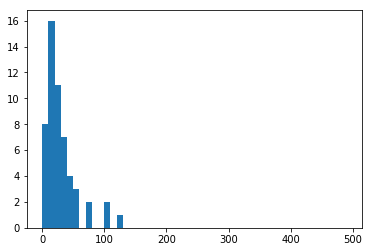

In [81]:
plt.hist(gen_tscores[2], np.arange(0, 500, 10))

In [484]:
param_stats.columns

Index(['cov_mean_01', 'cov_mean_02', 'cov_mean_03', 'cov_mean_04',
       'cov_mean_05', 'cov_mean_06', 'cov_mean_07', 'cov_mean_08',
       'cov_mean_09', 'cov_mean_10', 'cov_sd_01', 'cov_sd_02', 'cov_sd_03',
       'cov_sd_04', 'cov_sd_05', 'cov_sd_06', 'cov_sd_07', 'cov_sd_08',
       'cov_sd_09', 'cov_sd_10', 'cov_t_01', 'cov_t_02', 'cov_t_03',
       'cov_t_04', 'cov_t_05', 'cov_t_06', 'cov_t_07', 'cov_t_08', 'cov_t_09',
       'cov_t_10', 'mean_tscore', 'max_tscore', 'activation', 'batch_size',
       'beta_one', 'data_width', 'dropout_alpha', 'filter_width',
       'generator_input_size', 'learning_rate', 'length_scale',
       'min_conv_filters', 'min_data_width', 'seed', 'train_size'],
      dtype='object')

1 0 min_conv_filters activation
activation           leaky       relu      selu
min_conv_filters                               
32                9.321756  35.399666  6.948990
64                5.597113  13.342157  7.318620
128               5.411284  10.995506  5.922543
2 0 generator_input_size activation
activation               leaky       relu      selu
generator_input_size                               
16                    6.880341  13.506036  7.333469
32                    6.038967  13.342157  5.922543
128                   5.411284  10.995506  7.318620
2 1 generator_input_size min_conv_filters
min_conv_filters            32        64        128
generator_input_size                               
16                    10.292931  7.333469  6.880341
32                     6.948990  8.042471  5.922543
128                    7.871447  5.597113  5.411284
3 0 dropout_alpha activation
activation        leaky       relu      selu
dropout_alpha                               
0.00       

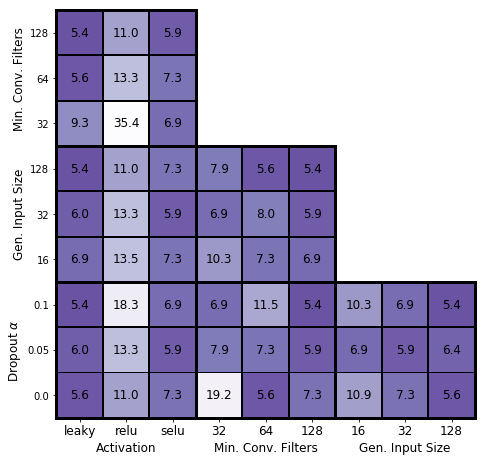

In [67]:
chart_cols = ["activation", "min_conv_filters", "generator_input_size", "dropout_alpha"]
col_names = ["Activation", "Min. Conv. Filters", "Gen. Input Size", "Dropout $\\alpha$"]
fig, axes = plt.subplots(len(chart_cols), len(chart_cols), figsize=(10, 10))
plt.subplots_adjust(wspace=0, hspace=0)
for r, row_col in enumerate(chart_cols):
    for c, col_col in enumerate(chart_cols):
        if r > c:
            val_grid = param_stats.groupby([row_col, col_col])["max_tscore"].min().unstack()
            for axis in ['top','bottom','left','right']:
                  axes[r,c].spines[axis].set_linewidth(3)
            axes[r,c].pcolormesh(val_grid, vmin=0,
                                vmax=21, cmap="Purples_r", edgecolor='k', lw=1)
            for (i, j), v in np.ndenumerate(val_grid):
                axes[r,c].text(j+0.5, i+0.5, "{0:0.1f}".format(v), ha="center", va="center", fontsize=12)
            axes[r,c].set_yticks([0.5, 1.5, 2.5])
            axes[r,c].set_xticks([0.5, 1.5, 2.5])
            if c == 0:
                axes[r,c].set_yticklabels(np.sort(param_stats[row_col].unique()))
                axes[r,c].set_ylabel(col_names[r], fontsize=12)
            else:
                axes[r,c].get_yaxis().set_visible(False)
            if r == len(chart_cols) - 1:
                axes[r,c].set_xticklabels(np.sort(param_stats[col_col].unique()), fontsize=12)
                axes[r,c].set_xlabel(col_names[c], fontsize=12)
            else:
                axes[r,c].get_xaxis().set_visible(False)
            print(r,c, row_col, col_col)
            print(param_stats.groupby([row_col, col_col])["max_tscore"].min().unstack())
        else:
            axes[r, c].set_visible(False)
plt.savefig("min_tscore_matrix.pdf", bbox_inches="tight", transparent=True)

activation
leaky    18.203439
relu     58.190426
selu     39.024602
dtype: float64 activation
leaky    37.424536
relu     72.302385
selu     47.154924
dtype: float64
activation
leaky    23.634659
relu     63.383729
selu     40.626421
dtype: float64 activation
leaky    27.533663
relu     70.149629
selu     45.436844
dtype: float64
min_conv_filters
32     42.653844
64     40.622593
128    36.962186
dtype: float64 min_conv_filters
32     51.727631
64     46.948777
128    49.724407
dtype: float64
activation
leaky    24.409913
relu     63.147932
selu     36.839623
dtype: float64 activation
leaky    26.009927
relu     73.808844
selu     47.810452
dtype: float64
min_conv_filters
32     45.227376
64     42.589445
128    40.817364
dtype: float64 min_conv_filters
32     49.179148
64     46.066573
128    46.026095
dtype: float64
generator_input_size
16     43.271477
32     42.380194
128    39.627149
dtype: float64 generator_input_size
16     45.843618
32     51.623018
128    46.934285
dtype: floa

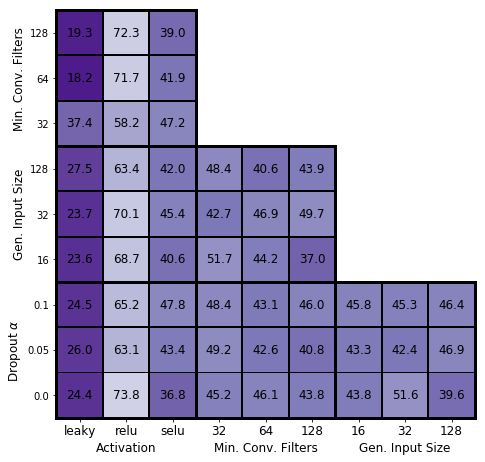

In [539]:
chart_cols = ["activation", "min_conv_filters", "generator_input_size", "dropout_alpha"]
col_names = ["Activation", "Min. Conv. Filters", "Gen. Input Size", "Dropout $\\alpha$"]
fig, axes = plt.subplots(len(chart_cols), len(chart_cols), figsize=(10, 10))
plt.subplots_adjust(wspace=0, hspace=0)
for r, row_col in enumerate(chart_cols):
    for c, col_col in enumerate(chart_cols):
        if r > c:
            val_grid = param_stats.groupby([row_col, col_col])["max_tscore"].mean().unstack()
            print(val_grid.min(), val_grid.max())
            for axis in ['top','bottom','left','right']:
                  axes[r,c].spines[axis].set_linewidth(3)
            axes[r,c].pcolormesh(val_grid, vmin=10,
                                vmax=100, cmap="Purples_r", edgecolor='k', lw=1)
            for (i, j), v in np.ndenumerate(val_grid):
                axes[r,c].text(j+0.5, i+0.5, "{0:0.1f}".format(v), ha="center", va="center", fontsize=12)
            axes[r,c].set_yticks([0.5, 1.5, 2.5])
            axes[r,c].set_xticks([0.5, 1.5, 2.5])
            if c == 0:
                axes[r,c].set_yticklabels(np.sort(param_stats[row_col].unique()))
                axes[r,c].set_ylabel(col_names[r], fontsize=12)
            else:
                axes[r,c].get_yaxis().set_visible(False)
            if r == len(chart_cols) - 1:
                axes[r,c].set_xticklabels(np.sort(param_stats[col_col].unique()), fontsize=12)
                axes[r,c].set_xlabel(col_names[c], fontsize=12)
            else:
                axes[r,c].get_xaxis().set_visible(False)
        else:
            axes[r, c].set_visible(False)
plt.savefig("mean_tscore_matrix.pdf", bbox_inches="tight", transparent=True)

In [589]:
param_stats["max_tscore"]

Index
1        94.554945
3       178.549806
5        97.015264
37       55.459702
39      100.685017
41      117.251069
73       64.454400
75       56.265527
77      116.359567
109      45.548169
111      27.328296
113      16.217929
145      45.280077
147      77.651450
149     107.272625
181      59.484464
183      34.729595
185      34.451296
217      68.733572
219     108.464466
221      82.184553
253      81.902629
255     102.743100
257      89.285076
289      90.761711
291     123.899159
293      86.236063
325      28.094223
327      43.319427
329      16.316521
           ...    
1585    102.517404
1587     15.729170
1589     10.390819
1621     17.547522
1623     23.238299
1625     11.872049
1657     12.684372
1659     18.009229
1661     26.188127
1693     12.840415
1695     21.237686
1697     11.495696
1729     55.944759
1731     24.607761
1733     15.098122
1765     49.943971
1767     12.442508
1769     32.950417
1801     43.904500
1803     20.761076
1805     13.758387
1837  